# Bollinger Band Enchancment: ATR bands

The first algorithmic strategy I ever backtested was the Bollinger Band strategy. I always found this strategy fascinating because any given dataset tends to revert back to its mean, and there is typically a range within which the data moves away from the mean.

Bollinger Bands generally perform well; however, they may not be as effective during trending market conditions. This can result in missed opportunities and ultimately lead to reduced profitability. To address this, I considered incorporating Average True Range (ATR) into the band computation, as it has the potential to adjust to changes in trends. This adjustment could potentially improve signal generation, even when the data begins to trend.

Let's walk through the strategy using Prospect Capital (PSEC) as the dataset. PSEC's price tends to move sideways, making it a suitable starting point for analysis. Afterwards, I will conduct a backtest using Apple Inc. (AAPL), which usually exhibits a trending behavior. By testing various parameters, we can determine the combination that yields the highest returns. Ultimately, we will assess if this strategy is capable of generating profits in the market.






##Strategy Class Creation

In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
import quantstats as qs

In [ ]:
class BackTestATRBands:

    def __init__(self, ticker, start_date, end_date , ma, dev):
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.ma = ma
        self.dev = dev
        self.signals_list = []
        self.positions_list = []



        # Call the basic methods in the __init__ constructor itself so that they are automatically executed
        # upon object creation
        self.fetch_data()
        self.indicators()
        self.signals()
        self.positions()
        self.returns()

    def fetch_data(self):
        self.df = yf.download(self.ticker, self.start_date, self.end_date)

    def indicators(self):
        self.df['ma'] = self.df['Adj Close'].rolling(window=self.ma, center=False).mean()
        self.df['ATR'] = self.df['High'] - self.df['Low']
        self.df['std_dev'] = self.df['Adj Close'].rolling(window=self.ma, center=False).std()


        self.df['upper_bb'] = self.df['ma'] + (self.df['std_dev'] * self.dev * self.df['ATR'])
        self.df['lower_bb'] = self.df['ma'] - (self.df['std_dev'] * self.dev * self.df['ATR'])

        self.df.dropna(inplace=True)


    def signals(self):
    # Create a 'signal' column initialized with 0
        self.df['signal'] = 0
        self.df.loc[self.df['Adj Close'] < self.df['lower_bb'], 'signal'] = 1
        self.df.loc[self.df['Adj Close'] > self.df['upper_bb'], 'signal'] = -1

    def positions(self):
        self.df['position'] = self.df['signal'].replace(to_replace=0, method='ffill')


    def returns(self):
        self.df['bnh_returns'] = np.log(self.df['Adj Close'] / self.df['Adj Close'].shift(1))
        self.df['strategy_returns'] = self.df['bnh_returns'] * self.df['position'].shift(1)
        print('Total return:', np.round(self.df['strategy_returns'].cumsum()[-1], 2))
        return self.df['strategy_returns'].cumsum()[-1]

    def analysis(self):
      # A plot to check if the strategy is working as planned:
        self.df[['upper_bb','lower_bb','Adj Close']].plot(figsize=(12,8))
        plt.show()

        self.df[['Adj Close','position']].plot(secondary_y='position', grid=True, figsize=(12, 8))
        #plt.figure()
        plt.show()

        # A plot to check how the strategy performs relative to buy & hold
        self.df[['bnh_returns','strategy_returns']].cumsum().plot(figsize=(15, 6), secondary_y='position', grid=True)
        plt.title("Buy & Hold' vs 'ATR BBbands' cumulative returns")
        plt.show()
        qs.reports.basic(self.df['strategy_returns'])

    @staticmethod
    def date_of_backtest():
        print('Date of backtest:', dt.datetime.now().date())

    # A class method
    @classmethod
    def about_this_backtest(cls):
        print('We are backtesting The ATR Expansion Strategy.')

##Backtest PSEC

Let's proceed with the first backtest using the standard parameters. We will utilize approximately two years of daily data and calculate the total return value. Afterward, we can visually examine the strategy's signals to assess if they are being correctly followed.

First Backtest Parameters:

1. Moving Average: 20
2. Deviation Factor: 2

By running this backtest, we will obtain insights into the performance of the strategy and gain an initial understanding of its effectiveness.








In [ ]:
start_date = dt.datetime(2021, 1, 1)
end_date = dt.datetime.now()

print('Start date:', start_date)
print('End date:', end_date)

Start date: 2021-01-01 00:00:00
End date: 2023-07-14 12:54:13.006816


In [ ]:
back = BackTestATRBands('PSEC', start_date, end_date, 20, 2)

[*********************100%***********************]  1 of 1 completed
Total return: -0.51


Lets take a look at the visual of the strategy.

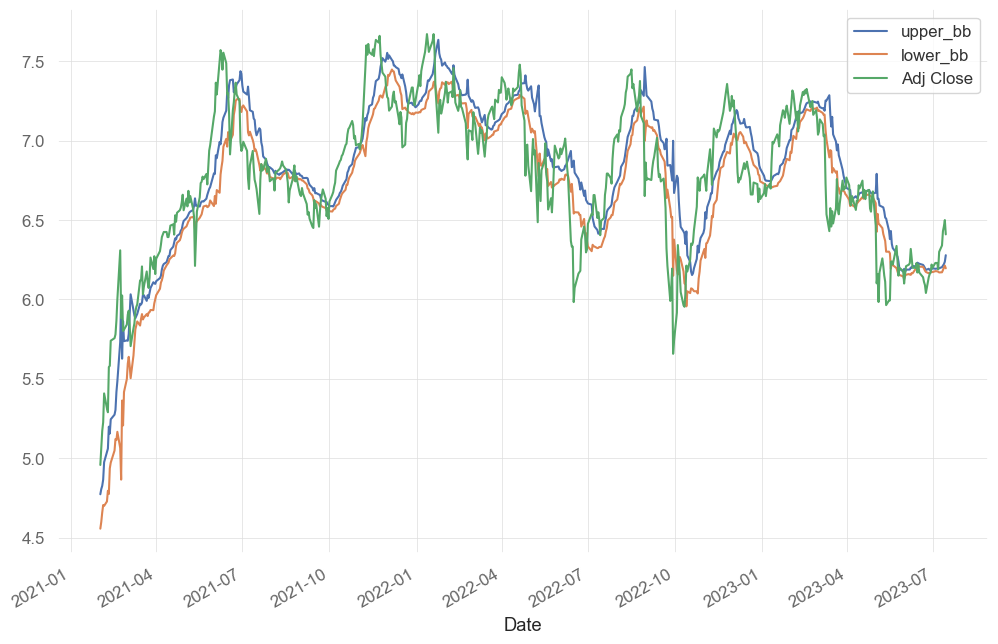

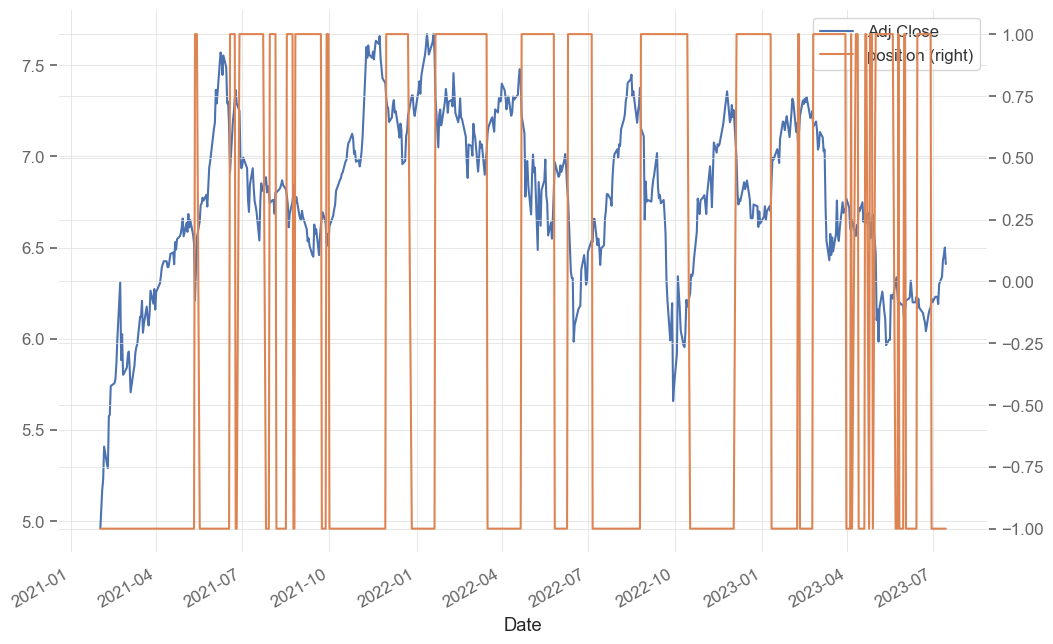

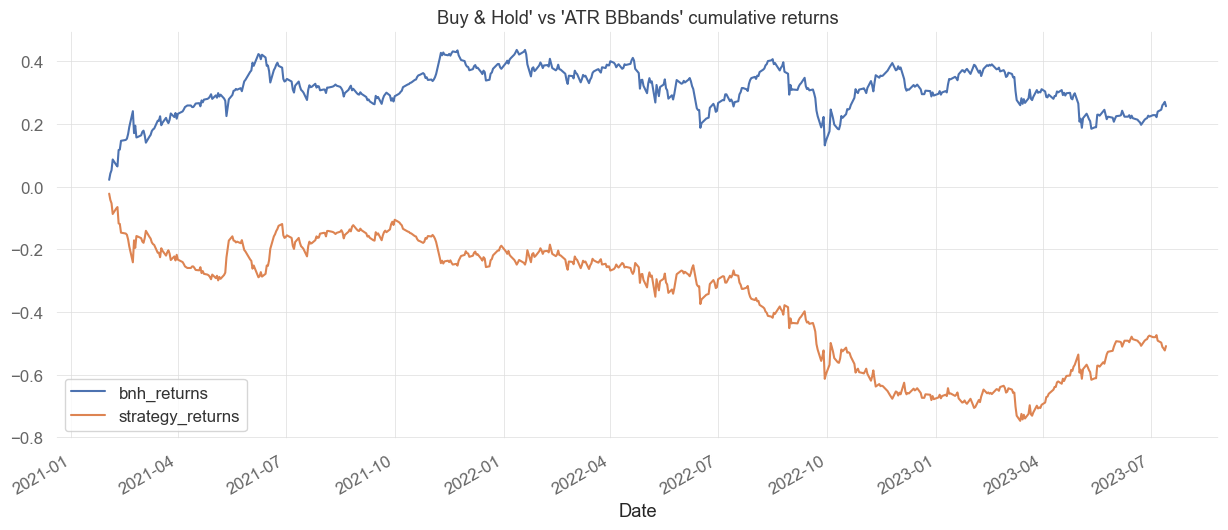

                    Strategy
------------------  ----------
Start Period        2021-02-01
End Period          2023-07-14
Risk-Free Rate      0.0%
Time in Market      98.0%

Cumulative Return   -44.57%
CAGR﹪              -21.43%

Sharpe              -0.81
Prob. Sharpe Ratio  10.12%
Sortino             -1.07
Sortino/√2          -0.76
Omega               0.87

Max Drawdown        -55.95%
Longest DD Days     892

Gain/Pain Ratio     -0.13
Gain/Pain (1M)      -0.52

Payoff Ratio        1.03
Profit Factor       0.87
Common Sense Ratio  0.87
CPC Index           0.41
Tail Ratio          1.0
Outlier Win Ratio   3.28
Outlier Loss Ratio  4.38

MTD                 -3.32%
3M                  11.54%
6M                  14.86%
YTD                 16.96%
1Y                  -22.88%
3Y (ann.)           -21.43%
5Y (ann.)           -21.43%
10Y (ann.)          -21.43%
All-time (ann.)     -21.43%

Avg. Drawdown       -55.95%
Avg. Drawdown Days  892
Recovery Factor     -0.8
Ulcer Index         0.34
Serenit

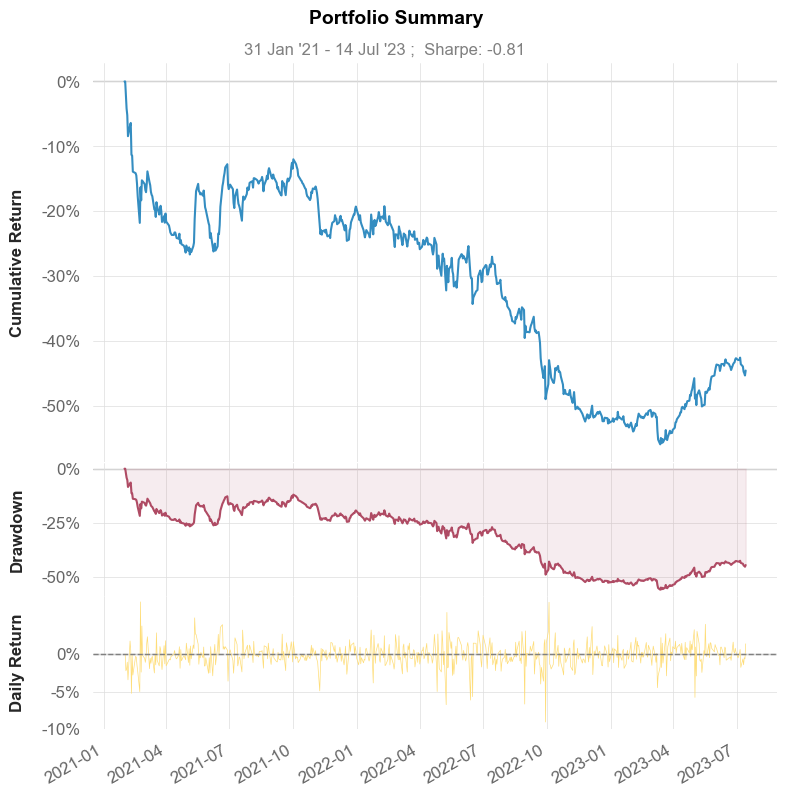

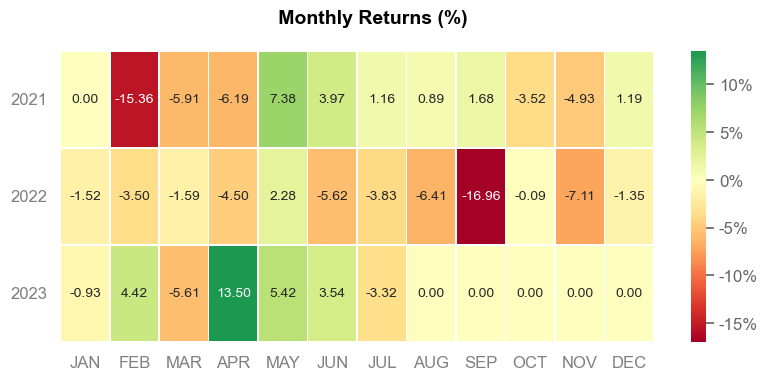

In [ ]:
back.analysis()

##Optimization of Strategy using PSEC data

It's important to note that a negative return from the initial backtest does not necessarily imply that the strategy cannot be profitable. We can proceed with optimizing the parameters to identify the pair that generates positive returns. Below is an optimization model that will iterate through the following ranges:

1. Moving Averages (MAs) ranging from 10 to 200 in increments of 1.
2. Deviation Factors ranging from 1 to 5 in increments of 0.1.

The optimization model will sort the results to identify the pair with the highest return. By performing this analysis, we aim to find the optimal combination of parameters that maximizes profitability.

Let's proceed with the optimization to determine the best pair of Moving Average and Deviation Factor.

In [ ]:
start1 = 10
end1 = 200
increment1 = 1
ma_list =np.arange(start1, end1 + increment1, increment1)

start = 1
end = 5
increment = 0.1
dev_list = np.arange(start, end + increment, increment)

ma =[]
dev =[]
net_returns= []

for i in ma_list:
    for j in dev_list:
        print('For',i,j)
        a = BackTestATRBands('PSEC', start_date, end_date, i, j)
        ma.append(i)
        dev.append(j)
        net_returns.append(a.returns())



For 10 1.0
[*********************100%***********************]  1 of 1 completed
Total return: -0.21
Total return: -0.21
For 10 1.1
[*********************100%***********************]  1 of 1 completed
Total return: -0.21
Total return: -0.21
For 10 1.2000000000000002
[*********************100%***********************]  1 of 1 completed
Total return: -0.22
Total return: -0.22
For 10 1.3000000000000003
[*********************100%***********************]  1 of 1 completed
Total return: -0.22
Total return: -0.22
For 10 1.4000000000000004
[*********************100%***********************]  1 of 1 completed
Total return: -0.22
Total return: -0.22
For 10 1.5000000000000004
[*********************100%***********************]  1 of 1 completed
Total return: -0.21
Total return: -0.21
For 10 1.6000000000000005
[*********************100%***********************]  1 of 1 completed
Total return: -0.21
Total return: -0.21
For 10 1.7000000000000006
[*********************100%***********************]  1 of 1 

In [ ]:
results = pd.DataFrame({'ma':ma, 'dev': dev, 'net_returns':net_returns})
results = results.sort_values(by='net_returns', ascending=False)
results

ma  dev  net_returns
3848  103  4.5     0.649822
3935  105  5.0     0.634757
3933  105  4.8     0.634757
3934  105  4.9     0.634757
4618  122  3.6     0.625987
...   ...  ...          ...
37     10  4.7    -0.724979
40     10  5.0    -0.728882
39     10  4.9    -0.746867
104    12  3.2    -0.761763
38     10  4.8    -0.785589

[7831 rows x 3 columns]

From about 7831 different backtests, it looks like the best possible parameters for this strategy using PSEC is:
1. ma = 103
2. dev = 4.5.

Before running the backtest for AAPL, lets take a look at the visuals for [103, 4.5] ATR band strategy


[*********************100%***********************]  1 of 1 completed
Total return: 0.65


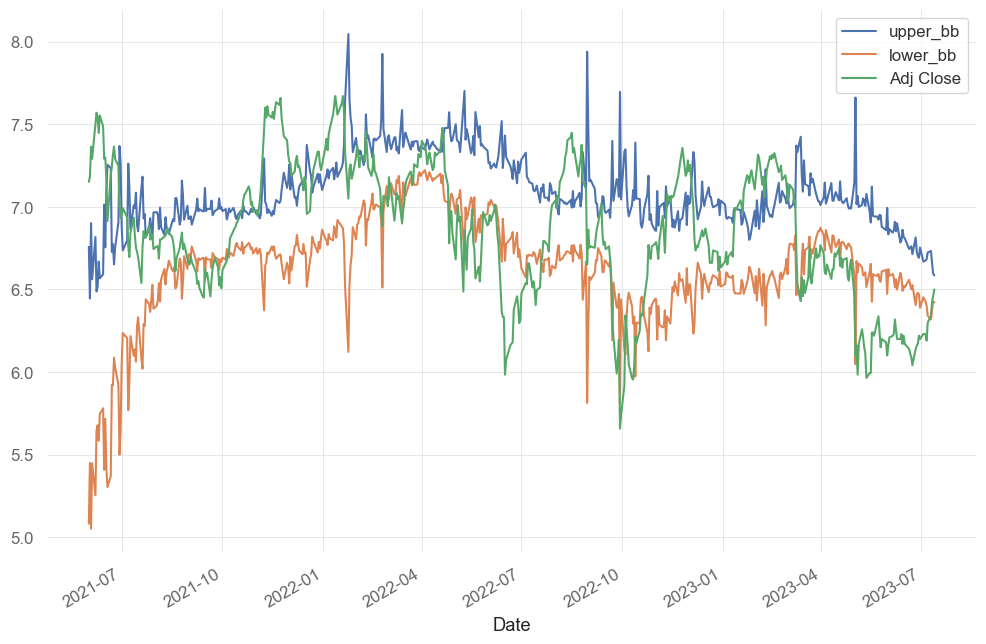

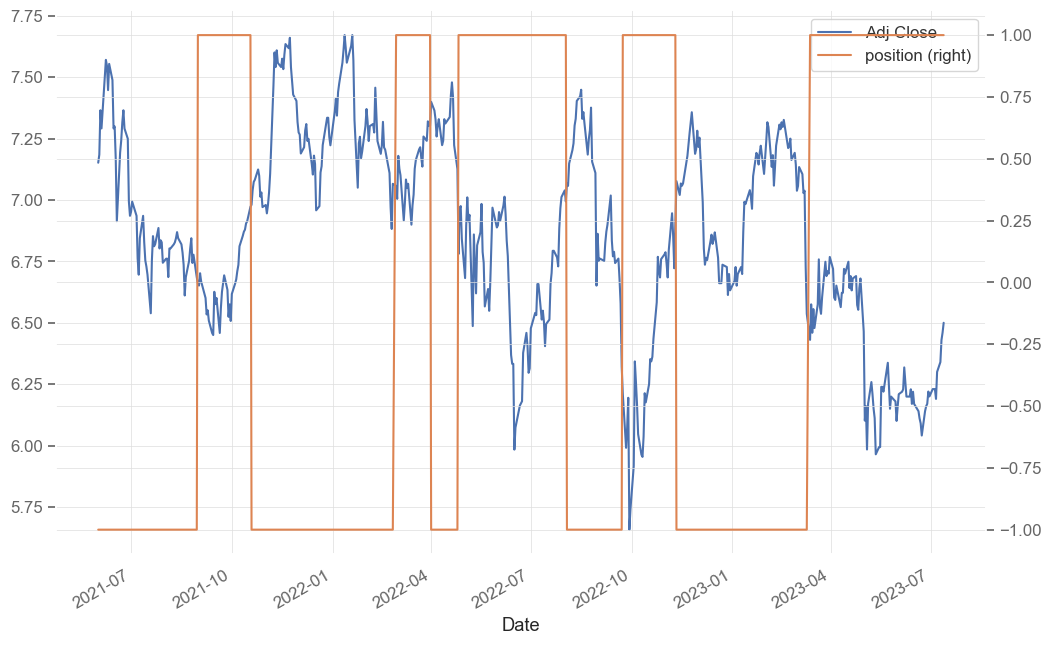

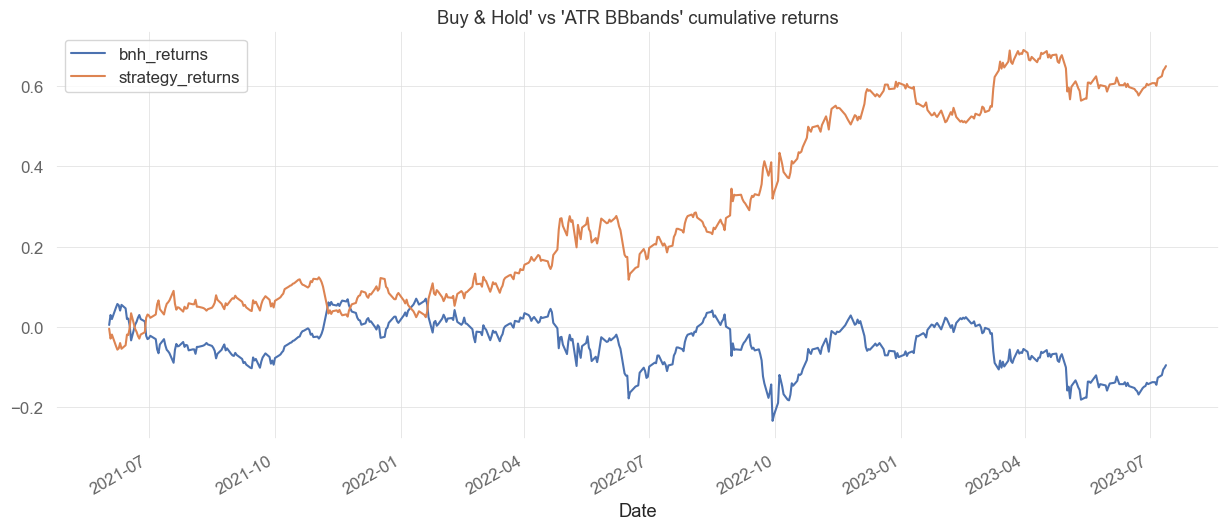

                    Strategy
------------------  ----------
Start Period        2021-06-01
End Period          2023-07-13
Risk-Free Rate      0.0%
Time in Market      98.0%

Cumulative Return   79.16%
CAGR﹪              31.74%

Sharpe              1.23
Prob. Sharpe Ratio  96.04%
Sortino             1.81
Sortino/√2          1.28
Omega               1.24

Max Drawdown        -15.55%
Longest DD Days     117

Gain/Pain Ratio     0.24
Gain/Pain (1M)      1.87

Payoff Ratio        1.13
Profit Factor       1.24
Common Sense Ratio  1.51
CPC Index           0.73
Tail Ratio          1.22
Outlier Win Ratio   3.39
Outlier Loss Ratio  4.21

MTD                 4.8%
3M                  -2.49%
6M                  8.6%
YTD                 2.93%
1Y                  50.48%
3Y (ann.)           31.74%
5Y (ann.)           31.74%
10Y (ann.)          31.74%
All-time (ann.)     31.74%

Avg. Drawdown       -4.42%
Avg. Drawdown Days  25
Recovery Factor     5.09
Ulcer Index         0.05
Serenity Index      2.5


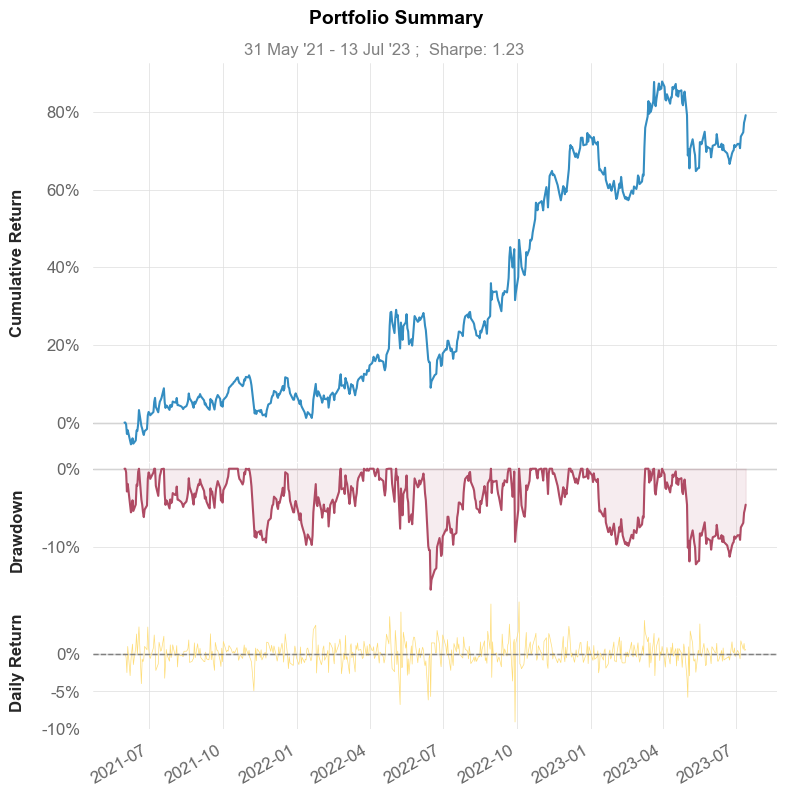

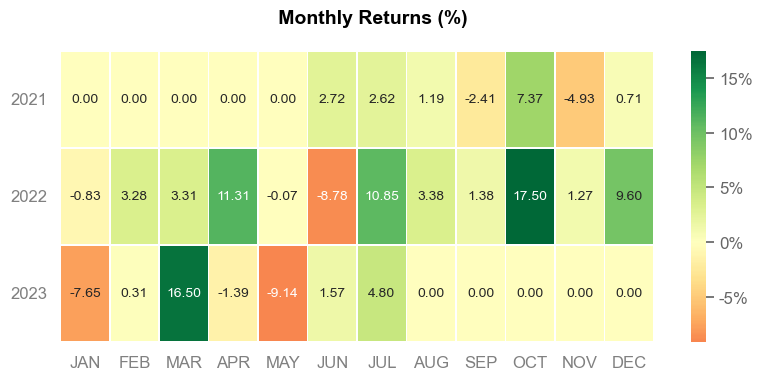

In [ ]:
optback = BackTestATRBands('PSEC', start_date, end_date, 103, 4.5)
optback.analysis()

###Things to think about:

A stock that experiences extreme highs and lows in its price may still be a good candidate for this type of strategy, depending on the underlying dynamics and patterns exhibited by the stock. The Bollinger Band strategy can potentially capitalize on price fluctuations and mean reversion, which could be advantageous in volatile stocks. However, it is essential to consider other factors such as liquidity, market conditions, and the overall trend of the stock before concluding its suitability for the strategy. Conducting thorough analysis and backtesting with historical data can provide valuable insights into the performance of the strategy on such stocks.

Now, let's proceed with running the backtest for AAPL using the Bollinger Band strategy. By analyzing the results, we can gain a better understanding of its performance and evaluate its profitability.

##Optimization for AAPL

In [ ]:
start1 = 10
end1 = 200
increment1 = 1
ma_list =np.arange(start1, end1 + increment1, increment1)

start = 1
end = 5
increment = 0.1
dev_list = np.arange(start, end + increment, increment)

ma =[]
dev =[]
net_returns1= []

for i in ma_list:
    for j in dev_list:
        print('For',i,j)
        a = BackTestATRBands('AAPL', start_date, end_date, i, j)
        ma.append(i)
        dev.append(j)
        net_returns1.append(a.returns())

For 10 1.0
[*********************100%***********************]  1 of 1 completed
Total return: -0.22
Total return: -0.22
For 10 1.1
[*********************100%***********************]  1 of 1 completed
Total return: -0.22
Total return: -0.22
For 10 1.2000000000000002
[*********************100%***********************]  1 of 1 completed
Total return: -0.26
Total return: -0.26
For 10 1.3000000000000003
[*********************100%***********************]  1 of 1 completed
Total return: -0.26
Total return: -0.26
For 10 1.4000000000000004
[*********************100%***********************]  1 of 1 completed
Total return: -0.26
Total return: -0.26
For 10 1.5000000000000004
[*********************100%***********************]  1 of 1 completed
Total return: -0.26
Total return: -0.26
For 10 1.6000000000000005
[*********************100%***********************]  1 of 1 completed
Total return: 0.0
Total return: 0.0
For 10 1.7000000000000006
[*********************100%***********************]  1 of 1 comp

In [ ]:
results = pd.DataFrame({'ma':ma, 'dev': dev, 'net_returns':net_returns1})
results = results.sort_values(by='net_returns', ascending=False)
results

ma  dev  net_returns
6478  168  1.0     0.190572
6396  166  1.0     0.174435
6437  167  1.0     0.174435
6355  165  1.0     0.174435
6232  162  1.0     0.159772
...   ...  ...          ...
617    25  1.2    -0.425263
576    24  1.2    -0.425263
126    13  1.3    -0.425263
412    20  1.2    -0.425263
330    18  1.2    -0.425263

[7831 rows x 3 columns]

Not as profitable as the backtest with PSEC. Lets take a look at the visuals of the most profitable parameter pair above to get a better understanding of why

[*********************100%***********************]  1 of 1 completed
Total return: 0.19


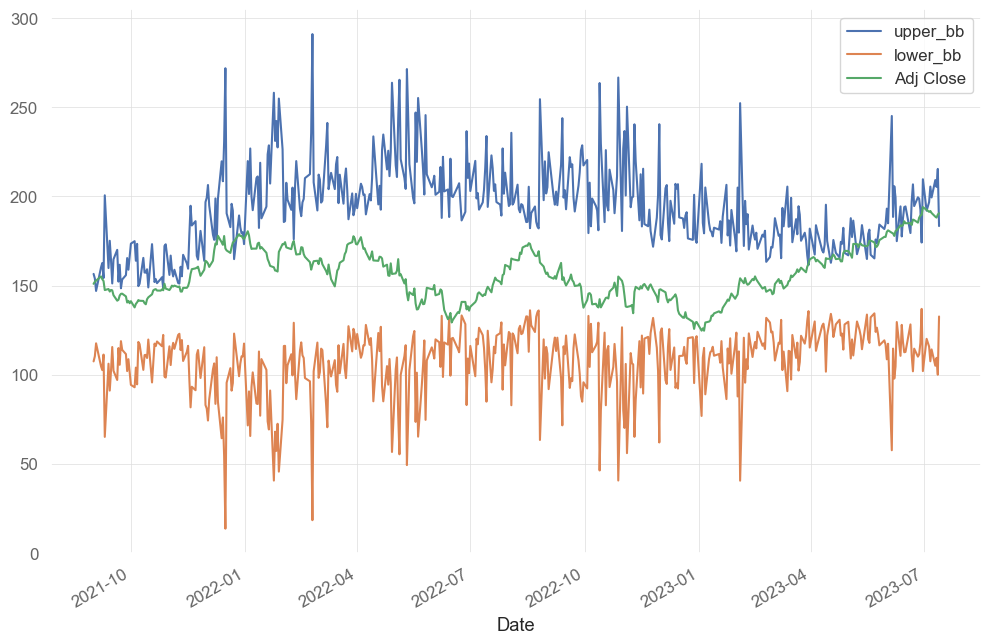

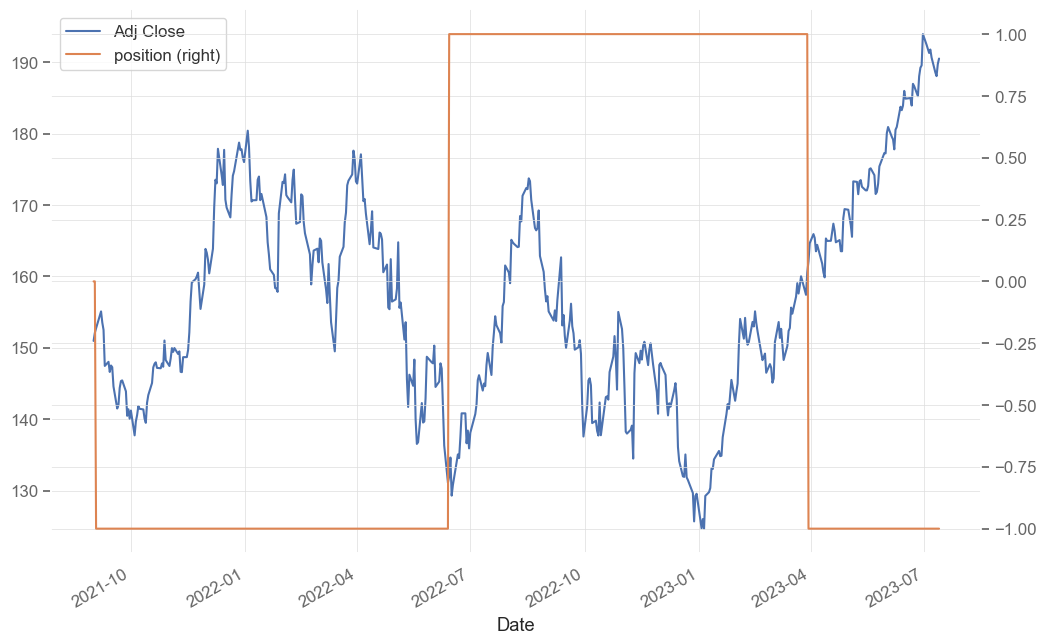

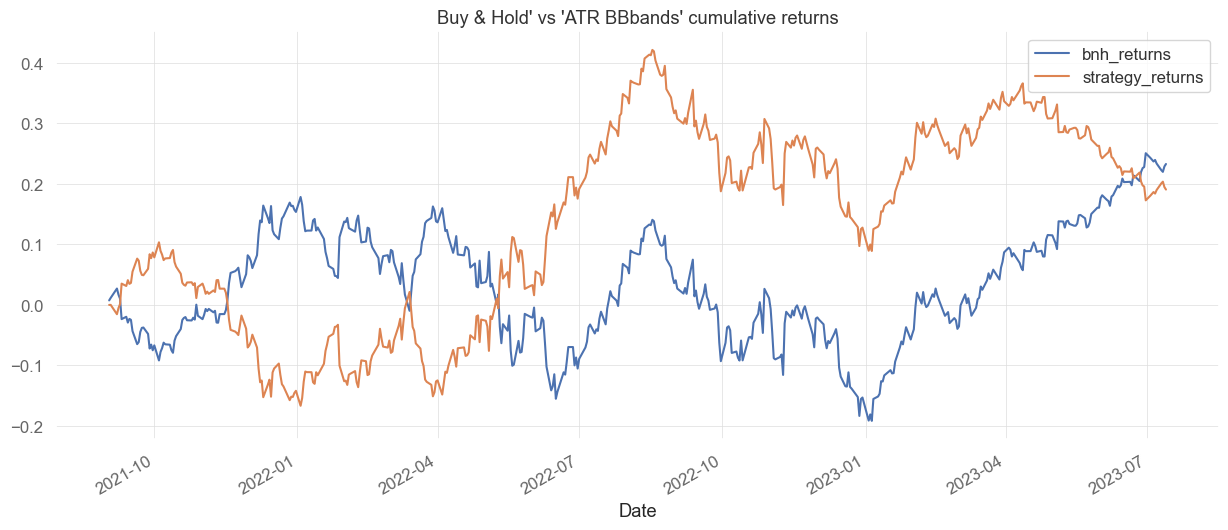

                    Strategy
------------------  ----------
Start Period        2021-09-01
End Period          2023-07-13
Risk-Free Rate      0.0%
Time in Market      99.0%

Cumulative Return   11.22%
CAGR﹪              5.87%

Sharpe              0.34
Prob. Sharpe Ratio  67.86%
Sortino             0.5
Sortino/√2          0.35
Omega               1.06

Max Drawdown        -30.23%
Longest DD Days     329

Gain/Pain Ratio     0.06
Gain/Pain (1M)      0.25

Payoff Ratio        1.02
Profit Factor       1.06
Common Sense Ratio  1.11
CPC Index           0.55
Tail Ratio          1.05
Outlier Win Ratio   3.47
Outlier Loss Ratio  3.13

MTD                 1.78%
3M                  -16.44%
6M                  2.66%
YTD                 5.22%
1Y                  -8.81%
3Y (ann.)           5.87%
5Y (ann.)           5.87%
10Y (ann.)          5.87%
All-time (ann.)     5.87%

Avg. Drawdown       -4.13%
Avg. Drawdown Days  33
Recovery Factor     0.37
Ulcer Index         0.16
Serenity Index      0.05


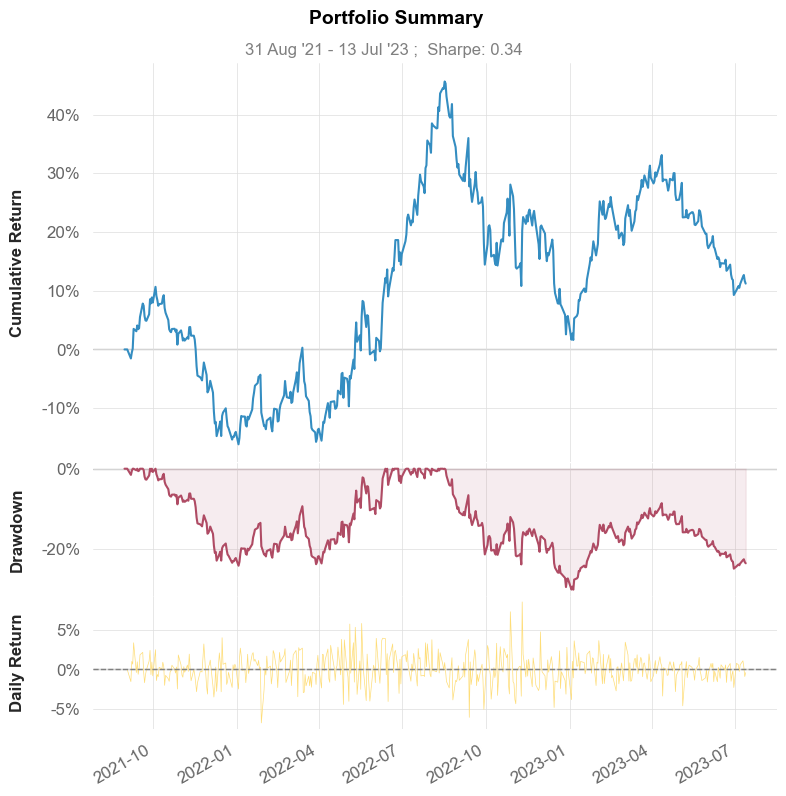

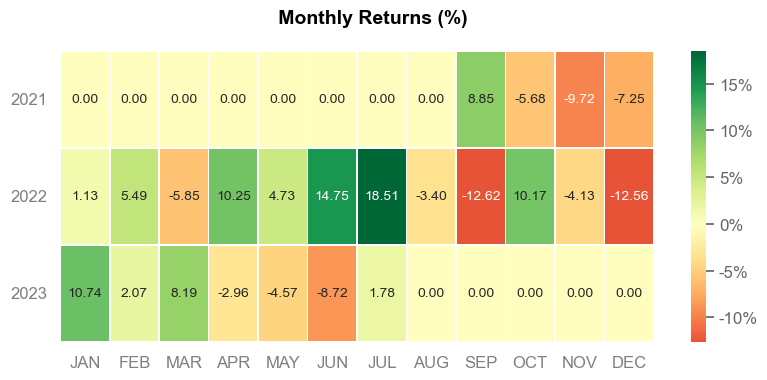

In [ ]:
AAPLoptback = BackTestATRBands('AAPL', start_date, end_date, 168, 1)
AAPLoptback.analysis()

#My conclusions:

1. The difference in profitability between PSEC and AAPL in this strategy for the given time period could be influenced by several factors, including the difference in Average True Range (ATR) calculations for both stocks. Since ATR is incorporated into the Bollinger Band strategy to adjust to trend changes, variations in ATR values can indeed impact the strategy's performance. It is possible that PSEC's ATR values were more conducive to generating profitable signals within the strategy during that specific time period compared to AAPL.

2. To analyze other variables that affect the returns of the strategy, you can consider conducting a statistical measure such as a correlation analysis or regression analysis. These analyses can help identify relationships between various factors and the strategy's returns. For example, you can explore the correlation between ATR values and the strategy's profitability, or analyze the impact of other technical indicators or fundamental variables on the strategy's performance. By conducting such analyses, you can gain insights into the factors that contribute to the strategy's success.

3. If ATR appears to be a key factor in the strategy's profitability, one approach you can consider is creating a stock screener to scan for stocks that exhibit similar ATR values to PSEC or any other stock that has proven to be profitable within the strategy. By filtering stocks based on their ATR values, you can identify potential candidates that align with the strategy's requirements. This approach allows you to focus on stocks that have a higher likelihood of fitting well within the strategy and potentially generating positive returns.